In [337]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import plotly.graph_objects as go
import vectorbt as vbt

sns.set_style('darkgrid')

# Efficient Frontier Analysis of Crypto-Based Portfolios

## Introduction

In recent years, cryptocurrencies have evolved from niche digital assets to mainstream financial instruments, attracting interest from both institutional and individual investors. With this shift comes the challenge of optimizing a portfolio that balances risk and return in the highly volatile crypto market. One effective approach to achieve this balance is through the concept of the *efficient frontier*, a core component of Modern Portfolio Theory (MPT) introduced by Harry Markowitz. The efficient frontier represents a set of optimal portfolios that offer the maximum expected return for a given level of risk or, conversely, the lowest risk for a specified return.

In this study, we aim to construct and analyze the efficient frontier for a portfolio consisting of selected cryptocurrencies. By evaluating the risk-return trade-offs of various crypto-based portfolios, this analysis seeks to provide insights into portfolio construction strategies that can optimize returns while managing the inherent risks associated with cryptocurrency investments.

## Objectives

1. **Data Collection**: Gather historical price data of selected cryptocurrencies from reliable sources.
2. **Portfolio Returns and Volatility Calculation**: Calculate the expected returns and standard deviations of individual assets and the portfolio as a whole.
3. **Efficient Frontier Construction**: Generate a series of portfolios with varying asset weight combinations to plot the efficient frontier.
4. **Optimization**: Identify portfolios on the efficient frontier that maximize the Sharpe Ratio (highest return per unit of risk) and minimize risk for a target return.
5. **Visualizations**: Create visual representations of the efficient frontier, individual asset risks and returns, and highlight optimal portfolios.

## Methodology

To conduct this analysis, we will:
- Define a set of cryptocurrencies to include in the study based on liquidity, market capitalization, and data availability.
- Calculate key metrics, including expected returns, covariances, and correlations, to assess the risk-return dynamics of each asset.
- Use optimization algorithms to identify the optimal portfolio weights that construct the efficient frontier.
- Evaluate the performance of these portfolios in terms of risk-adjusted return metrics like the Sharpe Ratio.

By the end of this notebook, we aim to gain a better understanding of how different combinations of cryptocurrencies can be structured to achieve optimal risk-adjusted returns, helping investors make more informed decisions in crypto portfolio management.

# Dataset: Daily Historical Crypto Data

This dataset contains daily historical price and volume data for selected cryptocurrencies, retrieved from Yahoo Finance using the `yfinance` library. Each row represents one day of trading activity for a given cryptocurrency, providing a snapshot of the asset's performance through various price and volume metrics. The data is essential for understanding daily price movements and volatility, which are crucial for financial analysis and portfolio optimization.

The dataset will focus on five major cryptocurrencies selected for their market capitalization, liquidity, and popularity among investors: Bitcoin (BTC), Ethereum (ETH), Binance Coin (BNB), Cardano (ADA), and Solana (SOL). These assets represent a diverse range of blockchain technologies and use cases, making them suitable candidates for portfolio analysis and risk-return optimization in the rapidly evolving crypto space.

To maintain relevance and account for the dynamic nature of the crypto market, only data from January 1, 2024, onward will be included in the analysis. This approach ensures that our study reflects the most recent market conditions, trends, and technological developments, which can significantly impact the performance and risk profiles of these assets over time.


In [338]:
TICKERS = ['BTC', 'ETH', 'ADA', 'SOL']
START_DATE = '2024-01-01'
RISK_FREE_RATE = 0.0369

In [339]:
tickers = list(map(lambda x: f'{x}-USD', TICKERS))
dataset = yf.download(tickers, start=START_DATE, group_by='ticker')
dataset.tail(3)

prices_df = dataset.loc[:, pd.IndexSlice[:,'Close']]
prices_df.columns = prices_df.columns.get_level_values(0)

[*********************100%%**********************]  4 of 4 completed


# Prices Analysis

This section examines the daily closing prices of selected cryptocurrencies, highlighting trends, volatility, and overall market behavior.

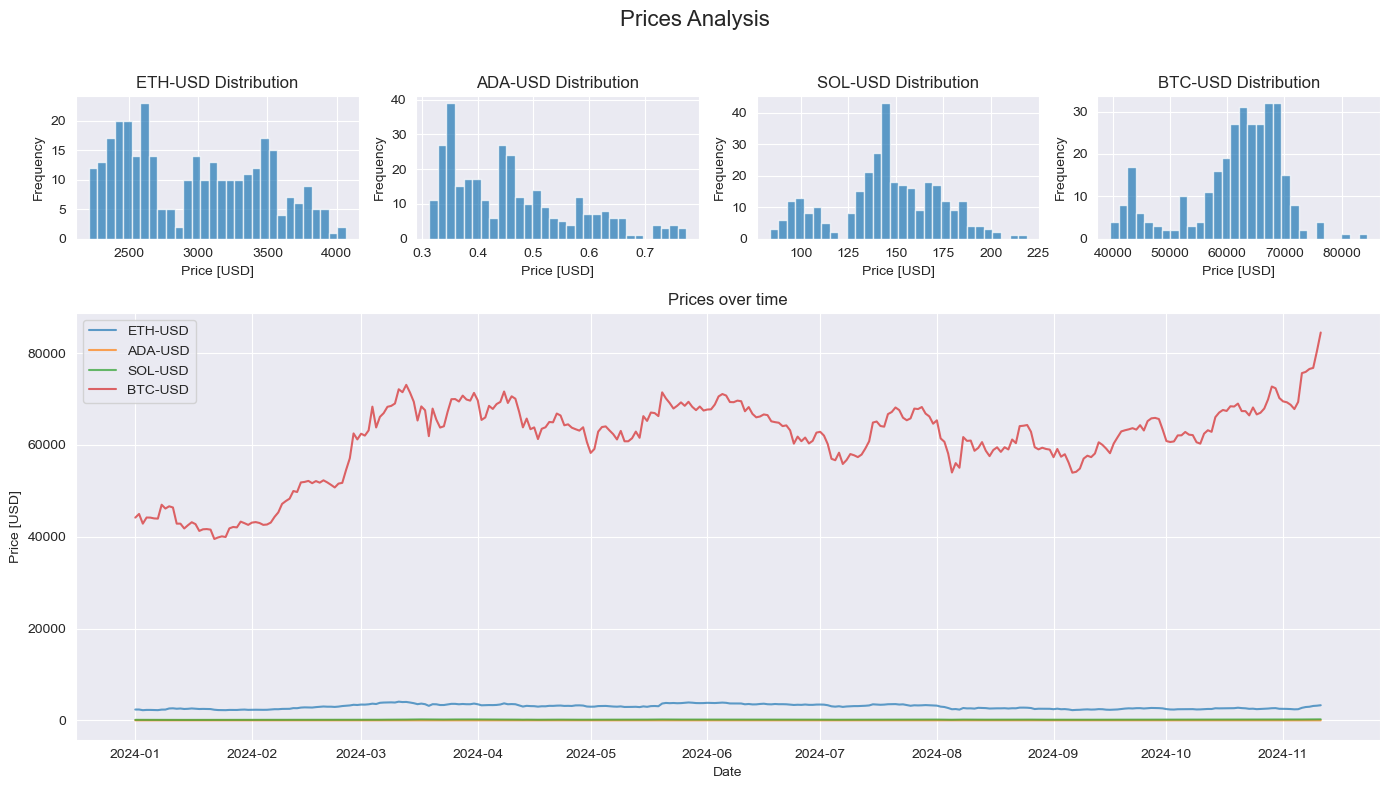

In [340]:
fig = plt.figure(figsize=(14, 8))
fig.suptitle('Prices Analysis', fontsize=16)

# Create a 2x2 grid with adjustable row heights
gs = GridSpec(2, len(prices_df.columns), height_ratios=[1, 3])  # Second row is three times taller


# First row: Distribution histograms
axs = []
for i, coin in enumerate(prices_df.columns):
    ax = fig.add_subplot(gs[0, i])
    ax.hist(prices_df[coin].dropna(), bins=30, alpha=0.7)
    ax.set_title(f'{coin} Distribution')
    ax.set_xlabel('Price [USD]')
    ax.set_ylabel('Frequency')
    axs.append(ax)

# Second row: Time series plot of returns (spans both columns)
ax3 = fig.add_subplot(gs[1, :])  # Spans the full row


# Plot returns evolution (second row, full width)
for coin in prices_df.columns:
    ax3.plot(prices_df.index, prices_df[coin], label=coin, alpha=0.7, )

ax3.set_title('Prices over time')
ax3.set_xlabel('Date')
ax3.set_ylabel('Price [USD]')
ax3.legend()


plt.tight_layout(rect=[0, 0, 1, 0.96])  

## Returns Analysis

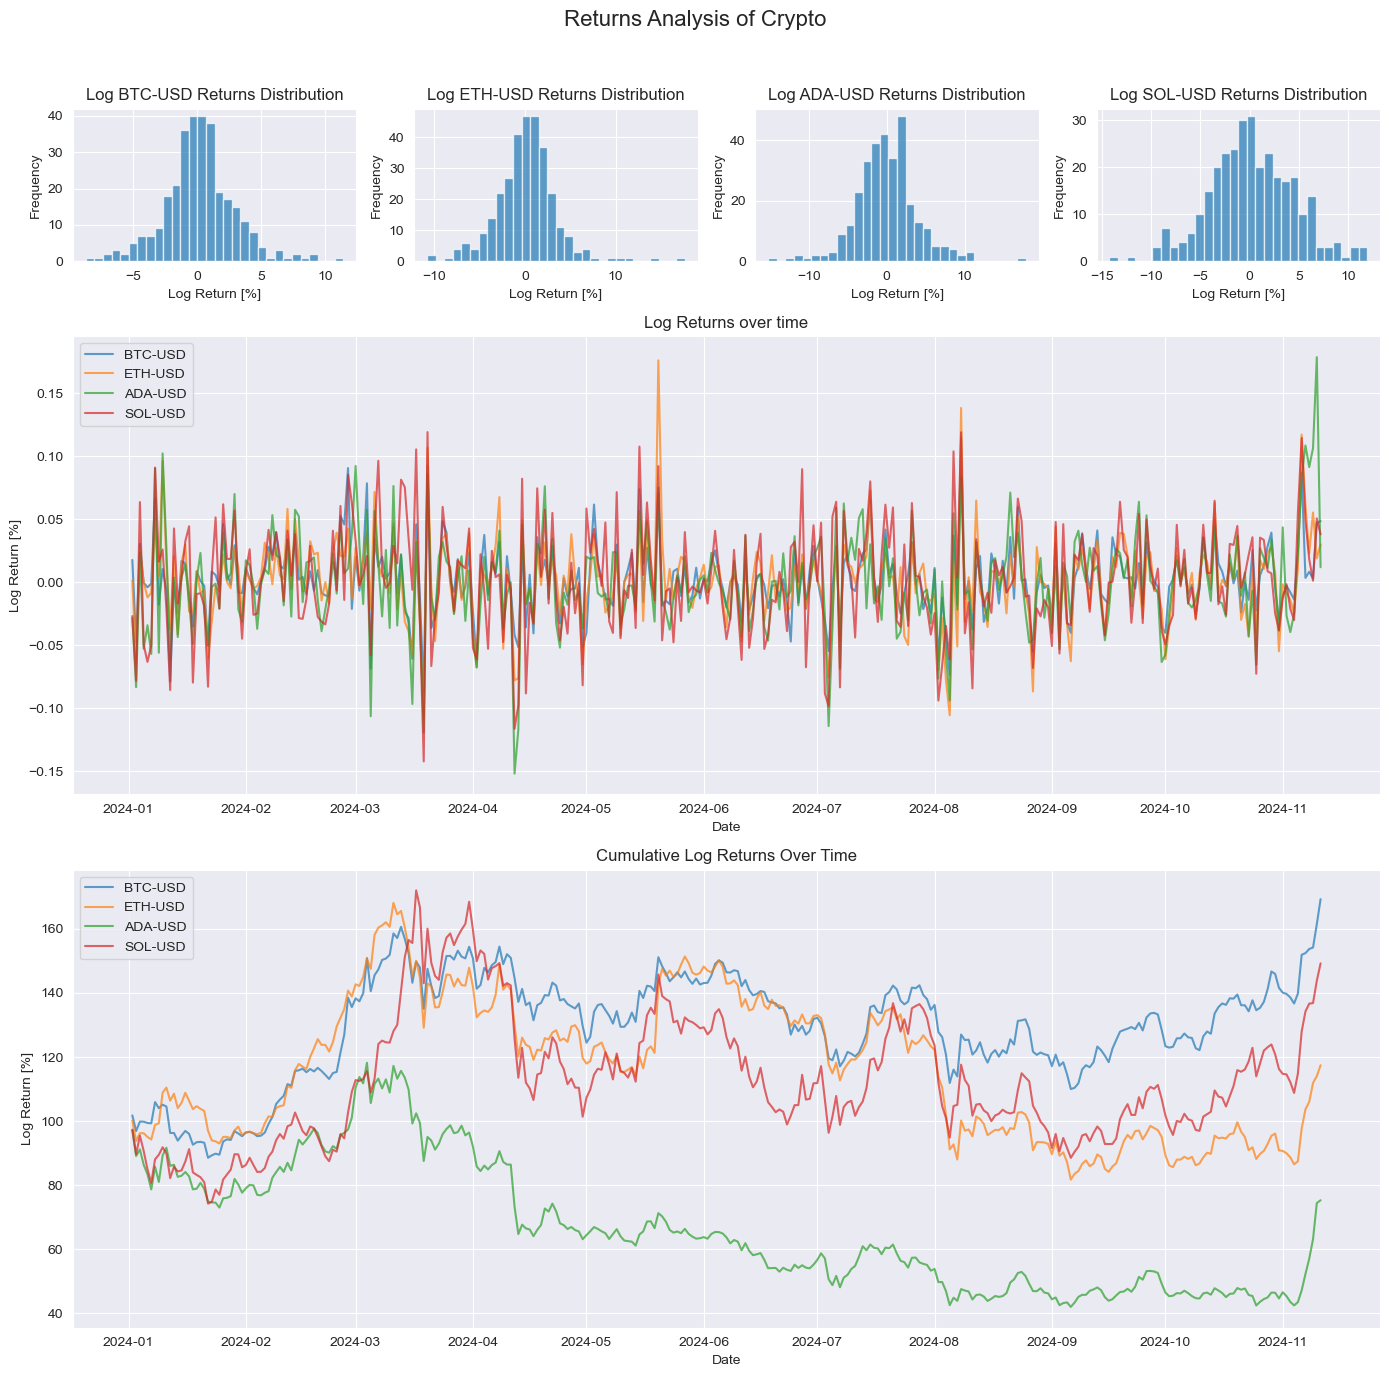

In [341]:
returns_df = prices_df.pct_change() * 100 # [%]
log_returns_df = np.log(1+prices_df.pct_change())

fig = plt.figure(figsize=(14, 14))
fig.suptitle('Returns Analysis of Crypto', fontsize=16)

# Create a 2x2 grid with adjustable row heights
gs = GridSpec(3, len(tickers), height_ratios=[1, 3, 3])  # Second row is three times taller


# First row: Distribution histograms
axs = []
for i, coin in enumerate(tickers):
    ax = fig.add_subplot(gs[0, i])
    ax.hist(100*log_returns_df[coin], bins=30, alpha=0.7)
    ax.set_title(f'Log {coin} Returns Distribution')
    ax.set_xlabel('Log Return [%]')
    ax.set_ylabel('Frequency')
    axs.append(ax)

# Second row: Time series plot of returns (spans both columns)
ax3 = fig.add_subplot(gs[1, :])  # Spans the full row


# Plot returns evolution (second row, full width)
for coin in tickers:
    ax3.plot(returns_df.index, log_returns_df[coin], label=coin, alpha=0.7)
ax3.set_title('Log Returns over time')
ax3.set_xlabel('Date')
ax3.set_ylabel('Log Return [%]')
ax3.legend()
ax3.grid(True)

# Third row: Time series plot of cum returns 
ax4 = fig.add_subplot(gs[2, :])

# Plot cum returns evolution
for coin in tickers:
    ax4.plot(returns_df.index, 100*(log_returns_df[coin]+1).cumprod(), label=coin, alpha=0.7)
ax4.set_title('Cumulative Log Returns Over Time')
ax4.set_xlabel('Date')
ax4.set_ylabel('Log Return [%]')
ax4.legend()
ax4.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leaves space for the title

### 3. Volatility

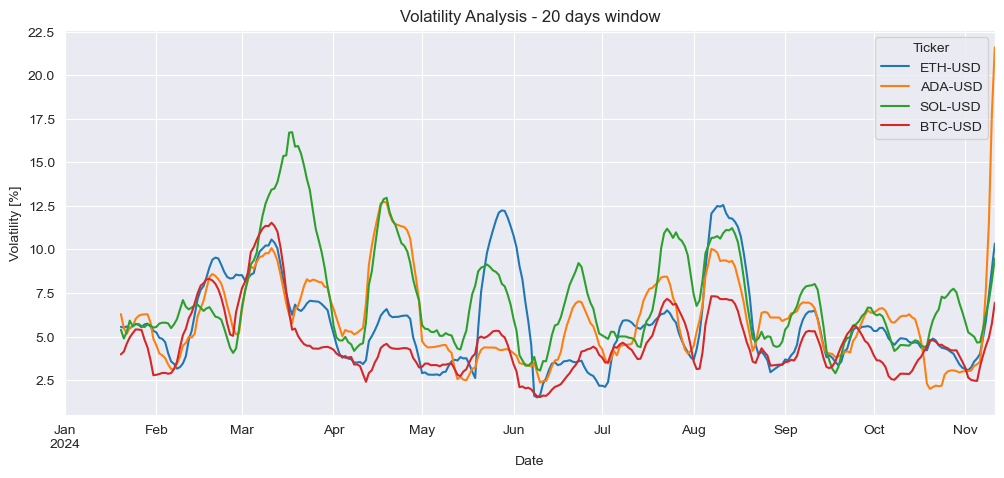

In [342]:
(100*(prices_df.rolling(20).std() / prices_df.rolling(20).mean())).plot(
    title='Volatility Analysis - 20 days window',
    xlabel='Date',
    ylabel='Volatility [%]',
    figsize=(12,5)
);


# Portfolio Opmization

### 1. Generate random portfolios

In [343]:

returns_mean = returns_df.mean()  # Mean returns
cov_matrix = returns_df.cov()  # Covariance matrix
n_assets = len(returns_mean)
n_portfolios = 25_000

# Generate random weights for all portfolios
weights = np.random.random((n_portfolios, n_assets))
weights /= np.sum(weights, axis=1, keepdims=True)  # Normalize


portfolio_returns = np.dot(weights, returns_mean) * 365  # Annualize returns 
portfolio_variance = np.einsum('ij,ji->i', weights, np.dot(cov_matrix.values, weights.T))  # Efficient calculation of portfolio variance
portfolio_std = np.sqrt(portfolio_variance) * np.sqrt(365)  # Annualize std


ptfs_df = pd.DataFrame(weights, columns=TICKERS)
ptfs_df['returns'] = portfolio_returns
ptfs_df['std'] = portfolio_std
ptfs_df['sharpe'] = (portfolio_returns - RISK_FREE_RATE) / portfolio_std  # Assuming 0.5 multiplier is a typo and removed

ptfs_df

,BTC,ETH,ADA,SOL,returns,std,sharpe
0,0.431791,0.343945,0.202916,0.021349,58.665929,64.756678,0.905374
1,0.318755,0.233586,0.315019,0.132640,72.154336,64.032307,1.126266
2,0.373363,0.079854,0.209415,0.337368,78.103108,59.553104,1.310867
3,0.275220,0.108092,0.296133,0.320555,81.324393,61.071136,1.331030
4,0.398004,0.048207,0.428822,0.124967,84.866564,65.303758,1.299001
...,...,...,...,...,...,...,...
24995,0.065623,0.423263,0.298418,0.212696,66.791877,65.199341,1.023860
24996,0.259467,0.414916,0.048907,0.276711,55.355896,60.855702,0.909019
24997,0.162457,0.322451,0.362159,0.152933,72.131384,65.601251,1.098980
24998,0.101176,0.097876,0.175902,0.625046,84.283512,56.983344,1.478443


### Max Return Portfolio

In [344]:
max_returns_portfolio = ptfs_df.iloc[ptfs_df['returns'].idxmax(),:] # Maximum returns point

### Max Sharpe Portfolio

In [345]:
max_sharpe_portfolio = ptfs_df.iloc[ptfs_df['sharpe'].idxmax(),:] # Maximum returns point

### Min Volatility Portfolio

In [346]:
min_volatility_portfolio = ptfs_df.iloc[ptfs_df['std'].idxmin(),:]

# Efficient Frontier

In [347]:

fig = go.Figure()

# Add scatter plot for the portfolios with color based on Sharpe Ratio
fig.add_trace(go.Scatter(
    x=ptfs_df['std'], 
    y=ptfs_df['returns'], 
    mode='markers', 
    showlegend=False,
    marker=dict(
        color=ptfs_df['sharpe'],
        colorscale='plasma',
        colorbar=dict(title="Sharpe Ratio"),
        size=5,
        showscale=True
    ),
))

# Mark Min Volatility Portfolio
fig.add_trace(go.Scatter(
    name="Minimum Volatility",
    x=[min_volatility_portfolio['std']],
    y=[min_volatility_portfolio['returns']],
    mode='markers',
    marker=dict(symbol='arrow-bar-down', size=15, color='red')
))

fig.add_trace(go.Scatter(
    name="Max Returns",
    x=[max_returns_portfolio['std']],
    y=[max_returns_portfolio['returns']],
    mode='markers',
    marker=dict(symbol='arrow-bar-up', size=15, color='cyan')
))

fig.add_trace(go.Scatter(
    name="Optimal Portfolio",
    x=[max_sharpe_portfolio['std']],
    y=[max_sharpe_portfolio['returns']],
    mode='markers',
    marker=dict(symbol='star', size=20, color='green')
))


# Fig config
fig.update_layout(
    title="Portfolios Space",
    xaxis_title="Expected Volatility",
    yaxis_title="Expected Return",
    legend=dict(
        yanchor="top",
        y=1.3,
        xanchor="left",
        x=0.6
    )
)

# Show the figure
fig.update_layout(template='plotly_dark')
fig.show()


In [348]:
print("-"*80)
print("Maximum Sharpe Ratio Portfolio Allocation\n")
print("Annualized Return:", round(max_sharpe_portfolio['returns'],2))
print("Annualized Volatility:", round(max_sharpe_portfolio['std'],2))
print("Sharpe Ratio:", round(max_sharpe_portfolio['sharpe'], 2))
print("\n")
print(100*pd.Series(max_sharpe_portfolio[TICKERS], name='Allocation [%]').to_frame().T)

print("-"*80)
print("Minimum Volatility Portfolio Allocation\n")
print("Annualized Return:", round(min_volatility_portfolio['returns'],2))
print("Annualized Volatility:", round(min_volatility_portfolio['std'],2))
print("Sharpe Ratio:", round(min_volatility_portfolio['sharpe'], 2))
print("\n")
print(100*pd.Series(min_volatility_portfolio[TICKERS], name='Allocation [%]').to_frame().T)

print("-"*80)
print("Maximum Returns Portfolio Allocation\n")
print("Annualized Return:", round(max_returns_portfolio['returns'],2))
print("Annualized Volatility:", round(max_returns_portfolio['std'],2))
print("Sharpe Ratio:", round(max_returns_portfolio['sharpe'], 2))
print("\n")
print(100*pd.Series(max_returns_portfolio[TICKERS], name='Allocation [%]').to_frame().T)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualized Return: 92.9
Annualized Volatility: 56.38
Sharpe Ratio: 1.65


                     BTC     ETH        ADA        SOL
Allocation [%]  0.579737  1.5356  18.690084  79.194579
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualized Return: 87.12
Annualized Volatility: 53.88
Sharpe Ratio: 1.62


                     BTC       ETH       ADA        SOL
Allocation [%]  3.768265  2.309662  1.205736  92.716337
--------------------------------------------------------------------------------
Maximum Returns Portfolio Allocation

Annualized Return: 109.95
Annualized Volatility: 79.07
Sharpe Ratio: 1.39


                     BTC       ETH        ADA       SOL
Allocation [%]  0.703724  2.472457  90.562058  6.261761


# Backtesting

In [349]:
weights = [max_sharpe_portfolio.drop(['sharpe', 'std', 'returns'])]
size = np.full_like(prices_df, np.nan)
size[0, :] = np.concatenate(weights) 

num_tests = 1
prices = prices_df.vbt.tile(num_tests, keys=pd.Index(np.arange(num_tests), name='symbol_group'))
prices = prices.vbt.stack_index(pd.Index(np.concatenate(weights), name='weights'))


portfolio = vbt.Portfolio.from_orders(
    close=prices,
    size=size,
    size_type='targetpercent',
    group_by='symbol_group',
    cash_sharing=True,
    freq='1D',
    fixed_fees=0.0, 
    init_cash=1_000_000,
    size_granularity=1
) # all weights sum to 1, no shorting, and 100% investment in risky assets

portfolio.stats()

Start                         2024-01-01 00:00:00
End                           2024-11-11 00:00:00
Period                          316 days 00:00:00
Start Value                             1000000.0
End Value                          1873021.449401
Total Return [%]                        87.302145
Benchmark Return [%]                    56.684289
Max Gross Exposure [%]                   97.74306
Total Fees Paid                               0.0
Max Drawdown [%]                        27.058721
Max Drawdown Duration           219 days 00:00:00
Total Trades                                    4
Total Closed Trades                             0
Total Open Trades                               4
Open Trade PnL                      873021.449401
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


In [350]:
portfolio.plot(silence_warnings=True).show()